# Needed libraries

In [41]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import folium
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

# Getting Toronto's total population data and Chinese population by neighborhood

In [45]:
toronto_population = pd.read_csv('C:\\Users\\Trust\\Downloads\\wellbeing_toronto.csv')
toronto_population.rename(columns={'After-Tax Household Income': 'Household Income'}, inplace=True)
toronto_population.drop(['Neighbourhood Id', 'Combined Indicators'], axis=1, inplace=True)
toronto_population.head()

,Neighbourhood,Household Income,Total Population,Chinese
0,West Humber-Clairville,59703.0,33312.0,470.0
1,Mount Olive-Silverstone-Jamestown,46986.0,32954.0,285.0
2,Thistletown-Beaumond Heights,57522.0,10360.0,110.0
3,Rexdale-Kipling,51194.0,10529.0,165.0
4,Elms-Old Rexdale,49425.0,9456.0,105.0


# Creating dataframe containing coordinates of each neighborhood and then merging it with Toronto population dataframe

In [47]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]
df = df[df.Borough!='Not assigned']
df = pd.merge(df, df_geo, left_on='Postcode', right_on='Postal Code').drop(['Postal Code', 'Postcode', 'Borough'], axis=1)
df = pd.merge(df, toronto_population, on='Neighbourhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Neighbourhood,Latitude,Longitude,Household Income,Total Population,Chinese
0,Victoria Village,43.725882,-79.315572,43743.0,17510.0,730.0
1,Rouge,43.806686,-79.194353,72784.0,46496.0,2100.0
2,Malvern,43.806686,-79.194353,53425.0,43794.0,3275.0
3,Highland Creek,43.784535,-79.160497,87321.0,12494.0,955.0
4,Flemingdon Park,43.725900,-79.340923,43511.0,21933.0,1015.0


# Getting the percentage of Southeast Asian in the total population

In [53]:
df.rename(columns={'   Chinese': 'Chinese'}, inplace=True)
df['Percentage of Chinese'] = df['Chinese'] / df['Total Population'] * 100
df.drop(['Total Population', 'Chinese'], axis=1, inplace=True)

# Create a Folium map 

In [55]:
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [56]:
# Folium mapping
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

# Defining Foursquare credentials and version

In [57]:
CLIENT_ID = 'WHH03MRSDOKYL4NSTHXULIJHLE4OZQMUNV55V1NCQSIHTVTC' # your Foursquare ID
CLIENT_SECRET = 'RQKZ4GIY4EQMDWCLCQXEGYYUI1QBKUUXHJDGLNFQRSJBVVVQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Get the top 100 venues that are in Toronto within a radius of 1500 meters

In [58]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)

In [59]:
# run the function above to each neighborhood and create a new dataframe called manhattan_venues
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])

toronto_venues

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
2,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
3,Victoria Village,43.725882,-79.315572,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
4,Victoria Village,43.725882,-79.315572,Jatujak,43.736208,-79.307668,Thai Restaurant
...,...,...,...,...,...,...,...
1791,Long Branch,43.602414,-79.543484,The Beer Store,43.594755,-79.533663,Beer Store
1792,Long Branch,43.602414,-79.543484,OUTFRONT Media Canada,43.604357,-79.532706,Print Shop
1793,Long Branch,43.602414,-79.543484,Douglas Park,43.609872,-79.537724,Park
1794,Long Branch,43.602414,-79.543484,Pendragon Comics,43.592465,-79.540797,Hobby Shop


Check how many venues were returned for each neighbourhood

In [60]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,84,84,84,84,84,84
Alderwood,43,43,43,43,43,43
Bathurst Manor,38,38,38,38,38,38
Bayview Village,16,16,16,16,16,16
Cliffcrest,39,39,39,39,39,39
Dorset Park,58,58,58,58,58,58
Flemingdon Park,85,85,85,85,85,85
Forest Hill North,100,100,100,100,100,100
Guildwood,30,30,30,30,30,30


# Analyzing each neighborhood with One Hot encoding

In [65]:
#one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix ='', prefix_sep='')
# add neighbourhood to column back to data frame
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Group rows by neighbourhood and by taking the mean of the frequency of occurrence of Asian restaurants

In [67]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Asian Restaurant']]
toronto_grouped.set_index('Neighbourhood', inplace=True)

Plotting a bar graph to showcase the frequency distribution of Asian restaurants in each neighbourhood.

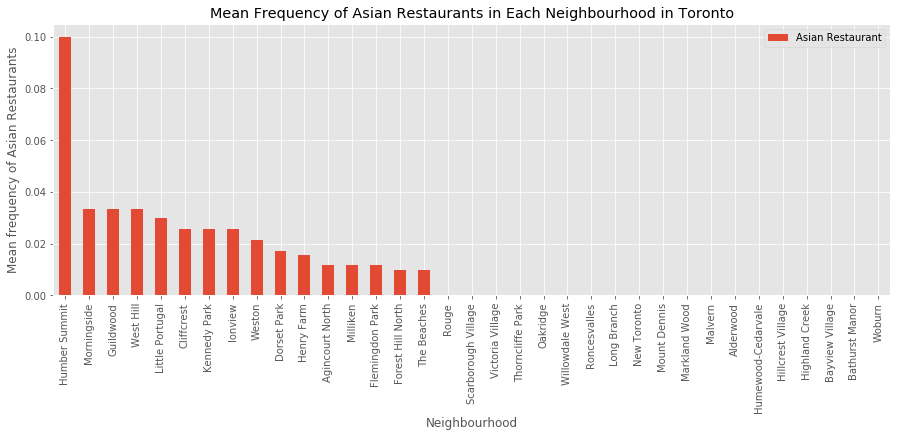

In [68]:
toronto_grouped.sort_values(by='Asian Restaurant', ascending=False, inplace=True)

%matplotlib inline
mpl.style.use('ggplot')

toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Asian Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Asian Restaurants')

plt.show()

The above graph shows that there are a lot of Asian restaurants in Humber Summit followed by Morningside, Guildwood and West Hill. Therefore, it is not recommended to build Asian restaurant at abovementioned areas.

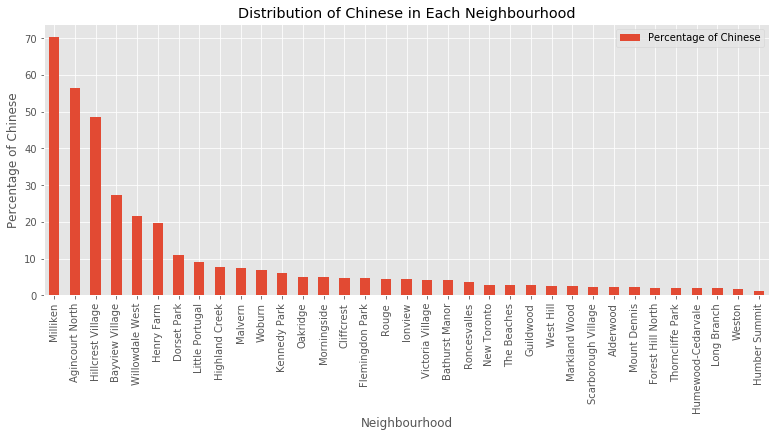

In [69]:
df_ethnic = df[['Neighbourhood', 'Percentage of Chinese']].set_index('Neighbourhood')

# sort by descending order
df_ethnic.sort_values(by='Percentage of Chinese', ascending=False, inplace=True)

#plot bar graph
df_ethnic.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Chinese in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage of Chinese')

plt.show()

It can be inferred from the graph that Milliken, AginCourt North and Hillcrest Village are the most populated areas with Chinese people.

# Finalizing a dataframe for clustering

In [70]:
# merge df with toronto_grouped
df_final = pd.merge(df, toronto_grouped, on='Neighbourhood')

In [71]:
df_final.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,Asian Restaurant
0,Victoria Village,43.725882,-79.315572,43743.0,4.169046,0.000000
1,Rouge,43.806686,-79.194353,72784.0,4.516518,0.000000
2,Malvern,43.806686,-79.194353,53425.0,7.478193,0.000000
3,Highland Creek,43.784535,-79.160497,87321.0,7.643669,0.000000
4,Flemingdon Park,43.725900,-79.340923,43511.0,4.627730,0.011765


# Clustering

In [72]:
# Normalizing the data
from sklearn.preprocessing import StandardScaler

X = df_final.values[:, 3:]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)
X

array([[-7.63184014e-01, -3.89814136e-01, -6.20973740e-01],
       [ 1.89181483e+00, -3.68124829e-01, -6.20973740e-01],
       [ 1.21967973e-01, -1.83255754e-01, -6.20973740e-01],
       [ 3.22082273e+00, -1.72926696e-01, -6.20973740e-01],
       [-7.84394018e-01, -3.61182906e-01, -7.26671103e-03],
       [-2.59537836e-01, -5.21861043e-01, -6.20973740e-01],
       [ 1.11591265e+00, -4.96273758e-01, -6.20973740e-01],
       [ 1.42501190e+00, -4.76954942e-01,  1.11786284e+00],
       [-1.84845709e-01, -3.35352991e-01,  1.11786284e+00],
       [-4.83431372e-01, -4.93951144e-01,  1.11786284e+00],
       [ 1.72478605e+00, -4.72051020e-01, -9.93227654e-02],
       [-3.82409585e-01, -2.16483440e-01, -6.20973740e-01],
       [ 5.11153266e-01,  2.38177002e+00, -6.20973740e-01],
       [-9.27833202e-02, -3.92469634e-01, -6.20973740e-01],
       [-1.22925557e+00, -5.21409899e-01, -6.20973740e-01],
       [-1.08883072e+00, -5.04484725e-01, -6.20973740e-01],
       [-4.05173770e-01,  5.72714540e-01

In [73]:
df_normalized = pd.DataFrame(X)
df_normalized.rename(columns={0: 'Household Income', 1: '% Chinese people', 2: '# of Asian Restaurants'}, inplace=True)
df_normalized.head()

,Household Income,% Chinese people,# of Asian Restaurants
0,-0.763184,-0.389814,-0.620974
1,1.891815,-0.368125,-0.620974
2,0.121968,-0.183256,-0.620974
3,3.220823,-0.172927,-0.620974
4,-0.784394,-0.361183,-0.007267


# Finding optimal number of clusters, k

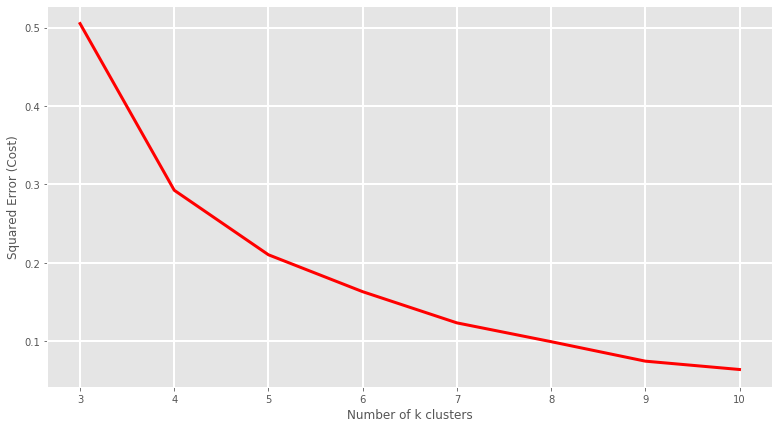

In [74]:
error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normalized)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

C:\Users\Trust\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001593428EFC8>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=10,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

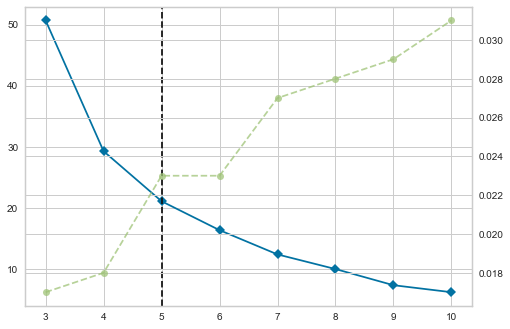

In [76]:
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11))

visualizer.fit(X)
visualizer

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 5 is the best value.

# Clustering the Toronto Neighborhood Using K-Means with K = 5

In [88]:
# set number of clusters
Ks = 5

# run k-means clustering
kmeans = KMeans(n_clusters=Ks, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 0, 0, 4, 4, 4])

In [90]:
#Creating dataframe that includes the cluster
df_normalized.drop(['Household Income', '% Chinese people'], axis=1, inplace=True)
df_clustered = pd.merge(df, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

# Visualizing cluster on a map

In [91]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start = 11)

#set color schemes for the clusters
x = np.arange(Ks)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examining clusters 

Cluster 0

In [92]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
0,0,Victoria Village,43.725882,-79.315572,43743.0,4.169046,-0.620974
1,0,Rouge,43.806686,-79.194353,72784.0,4.516518,-0.620974
2,0,Malvern,43.806686,-79.194353,53425.0,7.478193,-0.620974
3,0,Highland Creek,43.784535,-79.160497,87321.0,7.643669,-0.620974
5,0,Humewood-Cedarvale,43.693781,-79.428191,49252.0,2.053603,-0.620974
6,0,Markland Wood,43.643515,-79.577201,64297.0,2.463521,-0.620974
11,0,Woburn,43.770992,-79.216917,47908.0,6.945873,-0.620974
12,0,Hillcrest Village,43.803762,-79.363452,57682.0,48.570922,-0.620974
13,0,Bathurst Manor,43.754328,-79.442259,51076.0,4.126504,-0.620974
14,0,Thorncliffe Park,43.705369,-79.349372,38645.0,2.060830,-0.620974


Cluster 1

In [93]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]


,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
22,1,Humber Summit,43.756303,-79.565963,53272.0,1.087307,4.595536


Cluster 2

In [94]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
18,2,Ionview,43.727929,-79.262029,42971.0,4.398505,0.716593
19,2,Kennedy Park,43.727929,-79.262029,41776.0,6.044502,0.716593
23,2,Cliffcrest,43.716316,-79.239476,60384.0,4.800753,0.716593
25,2,Weston,43.706876,-79.518188,41356.0,1.861939,0.488922


Cluster 3

In [95]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
4,3,Flemingdon Park,43.725900,-79.340923,43511.0,4.627730,-0.007267
10,3,The Beaches,43.676357,-79.293031,70957.0,2.851579,-0.099323
16,3,Henry Farm,43.778517,-79.346556,47659.0,19.589137,0.194106
26,3,Dorset Park,43.757410,-79.273304,47630.0,10.978683,0.278424
27,3,Forest Hill North,43.696948,-79.411307,53978.0,2.069342,-0.099323
30,3,Agincourt North,43.815252,-79.284577,55893.0,56.538316,0.000039
31,3,Milliken,43.815252,-79.284577,55464.0,70.431281,0.000039


Cluster 4

In [96]:
df_clustered.loc[df_clustered['Cluster Label'] == 4]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Chinese,# of Asian Restaurants
7,4,Guildwood,43.763573,-79.188711,67678.0,2.773016,1.117863
8,4,Morningside,43.763573,-79.188711,50069.0,5.041535,1.117863
9,4,West Hill,43.763573,-79.188711,46803.0,2.500730,1.117863
17,4,Little Portugal,43.647927,-79.419750,52519.0,9.222958,0.943979


In conclusion, after analyzing all the clusters, cluster 0 is the best area to build Chinese restaurant. Specifically, Hillcrest Village is the best one as there are a lot of Chinese people but no Chinese restaurants.